In [1]:
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch.nn as nn
from torch.autograd import Variable
import torch

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

In [2]:
transform = transforms.Compose(
            [
            # 左右対称の画像を生成してデータ量を増やす(Augmentation)
            # transforms.RandomHorizontalFlip(),

            # 256*256に画像サイズを変更
            transforms.Resize((224, 224)),

            # PyTorchで利用するTensorの形式にデータを変換
             transforms.ToTensor(),

            ])

train_data = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
val_data = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
test_data = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)

data_size  = {"train":len(train_data), "validation":len(val_data)}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

In [3]:
model = models.resnet50(pretrained=True)
print(model)

# ネットワークの重みを固定
for parameter in model.parameters():
    parameter.requires_grad = False

# 最終的な出力を2個に設定
model.fc = nn.Linear(2048, 2)

if torch.cuda.is_available():
    model.cuda()


/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 下を別の方法で見る

In [4]:
def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_val=False):
  print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("VAL  " if is_val else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')

def cal_acc(output,label):
  p_arg = torch.argmax(output,dim = 1)
  return torch.sum(label == p_arg)

def Train_Eval(model,criterion,optimizer,data_loader,device,epoch,max_epoch,is_val = False):
  total_loss = 0.0
  total_acc = 0.0
  counter = 0
  model.eval() if is_val else model.train()
  for n,(data,label) in enumerate(data_loader):
    counter += data.shape[0]
    optimizer.zero_grad()
    data = data.to(device)
    label = label.to(device)
    if is_val:
      with torch.no_grad():
        output = model(data)
    else:
      output = model(data)
    loss = criterion(output,label)
    total_loss += loss.item()
    total_acc += cal_acc(output,label)
    
    if is_val != True:
      loss.backward()
      optimizer.step()
    show_score(epoch+1,max_epoch,n+1,len(data_loader),total_loss/(n+1) , total_acc/counter,is_val=is_val)
  print()
  return total_loss , total_acc

In [5]:
lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()
EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_loss = None

for epoch in range(EPOCHS):
  train_loss,train_acc = Train_Eval(model,criterion,optimizer,train_loader,DEVICE,epoch,EPOCHS) 
  val_loss,val_acc    = Train_Eval(model,criterion,optimizer,val_loader,DEVICE,epoch,EPOCHS,is_val=True)

  ## best_lossより小さなval_lossが出力された場合のみモデルを保存する。##
  if best_loss is None or val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), './best_ckpt2.pth')
  #################################################################
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)


TRAIN EPOCH[001/100] ITR [0562/0562] LOSS:0.48173 ACC:79.810692
VAL   EPOCH[001/100] ITR [0091/0091] LOSS:0.38365 ACC:85.221001
TRAIN EPOCH[002/100] ITR [0562/0562] LOSS:0.37443 ACC:85.122498
VAL   EPOCH[002/100] ITR [0091/0091] LOSS:0.34892 ACC:85.497246
TRAIN EPOCH[003/100] ITR [0562/0562] LOSS:0.34138 ACC:86.703789
VAL   EPOCH[003/100] ITR [0091/0091] LOSS:0.33878 ACC:85.842545
TRAIN EPOCH[004/100] ITR [0562/0562] LOSS:0.33279 ACC:86.703789
VAL   EPOCH[004/100] ITR [0091/0091] LOSS:0.32708 ACC:86.395035
TRAIN EPOCH[005/100] ITR [0562/0562] LOSS:0.32365 ACC:87.305122
VAL   EPOCH[005/100] ITR [0091/0091] LOSS:0.31999 ACC:86.671272
TRAIN EPOCH[006/100] ITR [0562/0562] LOSS:0.30859 ACC:88.084633
VAL   EPOCH[006/100] ITR [0091/0091] LOSS:0.33573 ACC:85.221001
TRAIN EPOCH[007/100] ITR [0562/0562] LOSS:0.30520 ACC:87.650337
VAL   EPOCH[007/100] ITR [0091/0091] LOSS:0.32123 ACC:86.464088
TRAIN EPOCH[008/100] ITR [0562/0562] LOSS:0.29687 ACC:88.485519
VAL   EPOCH[008/100] ITR [0091/0091] LOS

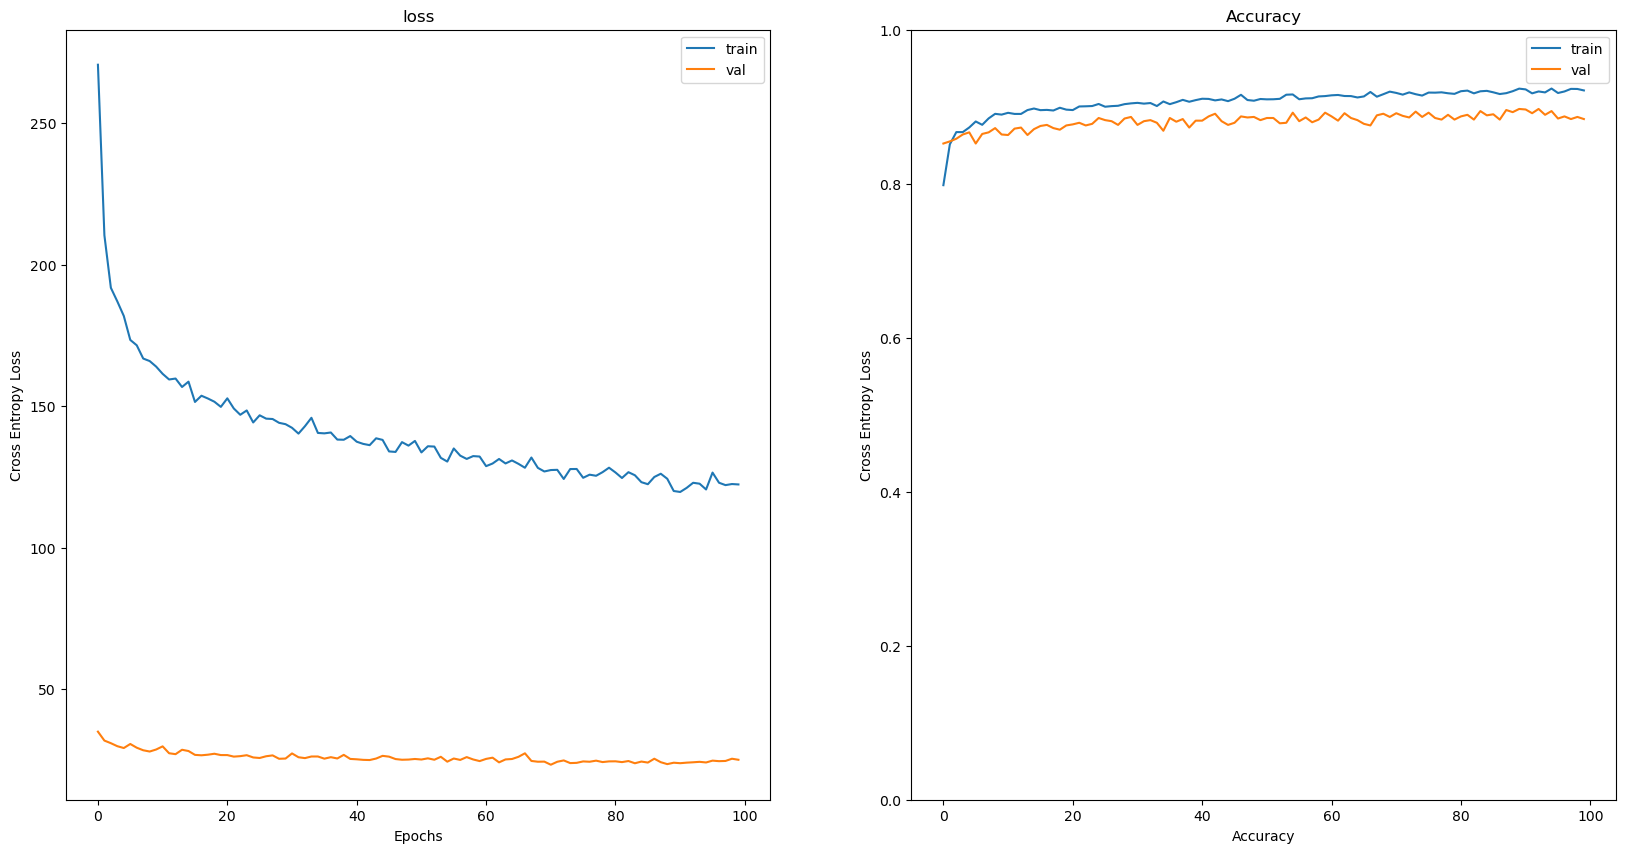

In [6]:
from matplotlib import pyplot as plt
from random import randint, random

## 描画データの準備
x = list(range(EPOCHS))
val_len = len(val_data)
train_len = len(train_data)
y1 = train_loss_list
y2 = val_loss_list

tensor_y3 = [x/train_len for x in train_acc_list]
tensor_y4 = [x/val_len for x in val_acc_list]

y3 = []
y4 = []

for acc in tensor_y3:
    acc = acc.to('cpu').detach().numpy().copy()
    y3.append(acc)

for acc in tensor_y4:
    acc = acc.to('cpu').detach().numpy().copy()
    y4.append(acc)


## 損失のグラフ描画
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 2, 1)

## グラフのラベル・タイトルを設定
ax.set_title("loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

## グラフをプロット
ax.plot(x, y1,label="train")
ax.plot(x, y2,label="val")

##凡例を描画
ax.legend()

## 精度のグラフ描画
ax = fig.add_subplot(1, 2, 2)
## グラフのラベル・タイトルを設定
plt.ylim([0,1])
ax.set_title("Accuracy")
ax.set_xlabel('Accuracy')
ax.set_ylabel('Cross Entropy Loss')

## グラフをプロット
ax.plot(x, y3,label="train")
ax.plot(x, y4,label="val")

##凡例を描画
ax.legend()

plt.show()

In [8]:
model.load_state_dict(torch.load('./best_ckpt2.pth'))

def test_model(model, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    current_loss = 0.0
    current_corrects = 0

    for data in test_loader:
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)

        current_loss += loss.item() * inputs.size(0) 
        current_corrects += torch.sum(preds == labels)

    epoch_loss = current_loss / len(test_data)

    epoch_acc = current_corrects.item() / len(test_data)

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return model

test_model = test_model(model, criterion)

Loss: 0.2913 Acc: 0.8792
